## Import all library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pywt 
from PIL import Image
from utility import *

## Determine suitable constant to divide
* This is done by Visualize the min, max, mean, Q-10%, Q2, Q-90%, std  for each eeg file
* Choose the minimum of Q-10%, OR maximum of Q-90% as the constant to divide the whole eeg file
 

In [2]:
# Create empty dataframe
df_summary_spike    = pd.DataFrame(columns=["EEG file"] + AVE_CHANNELS_NAME)
df_summary_no_spike = pd.DataFrame(columns=["EEG file"] + AVE_CHANNELS_NAME)
df_summary_spike

Empty DataFrame
Columns: [EEG file, F7-AVE, T3-AVE, T5-AVE, Fp1-AVE, F3-AVE, C3-AVE, P3-AVE, O1-AVE, Fz-AVE, Cz-AVE, Pz-AVE, O2-AVE, P4-AVE, C4-AVE, F4-AVE, Fp2-AVE, T6-AVE, T4-AVE, F8-AVE]
Index: []

In [3]:
def append_result(num, df_summary, df):
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Max)"]  , df.max(axis=0)[0].numpy() ))           # Add in the maximum value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Min)"]  , df.min(axis=0)[0].numpy() ))           # Add in the minimum value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Q-90%)"], df.quantile(0.10,axis=0).numpy() )) # Add in the 0.1 quantile value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Q2)"]   , df.quantile(0.50,axis=0).numpy() )) # Add in the Q2 value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Q-10%)"], df.quantile(0.90,axis=0).numpy() )) # Add in the 0.9 quantile value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Mean)"] , df.mean(axis=0).numpy() ))          # Add in the mean value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Std)"]  , df.std(axis=0).numpy() ))           # Add in the std value for each channel

    return df_summary


def get_list_seperately(df_summary):
    lengths      = len(df_summary)
    num_channels = len(AVE_CHANNELS_NAME)
    max_list, min_list, Q1_list, Q2_list, Q3_list, mean_list, std_list = np.zeros((lengths//7,num_channels)), np.zeros((lengths//7,num_channels)), np.zeros((lengths//7,num_channels)), np.zeros((lengths//7,num_channels)), np.zeros((lengths//7,num_channels)), np.zeros((lengths//7,num_channels)), np.zeros((lengths//7,num_channels))
    
    for i in range(lengths//7):
        max_list[i] = df_summary.iloc[i*7]
        min_list[i] = df_summary.iloc[i*7+1]
        Q1_list[i]  = df_summary.iloc[i*7+2]
        Q2_list[i]  = df_summary.iloc[i*7+3]
        Q3_list[i]  = df_summary.iloc[i*7+4]
        mean_list[i]= df_summary.iloc[i*7+5]
        std_list[i] = df_summary.iloc[i*7+6]
        
    dict1 = {"Max":max_list, "Min":min_list, "Q1":Q1_list, "Q2":Q2_list, "Q3":Q3_list, "mean":mean_list, "std":std_list}
    return dict1

def plot_summary(df_summary, title):
    dict1 = get_list_seperately(df_summary)
    
    for key in dict1:
        fig, ax = plt.subplots(len(AVE_CHANNELS_NAME),1,figsize=(20,40))
        for i, col in enumerate(AVE_CHANNELS_NAME):
            ax[i].plot(dict1[key][:,i], '--.',label=key)
            ax[i].set_title(col)
            ax[i].legend()

        plt.savefig(f"{VIS_FILE_DIRC}/{key}_{title}.png", transparent = False,  facecolor = 'white')

In [4]:
%%time
for num in range(1,98):
    df              = get_df(f'{CSV_FILE_DIRC}/eeg{num}.csv')       # Get the dataframe from the filename
    spike_locations = get_spike_location(num)                       # Get the spike label from the annotation.json
    data, label     = get_data_n_label(df, spike_locations)         # Get the data in epoch, and its corresponding label
    
    if sum(label) == 0: # no spike:
        df_summary_no_spike = append_result(num, df_summary_no_spike, data.reshape(-1, len(AVE_CHANNELS_NAME))) 
    else:
        df_summary_spike    = append_result(num, df_summary_spike   , data[label==1].reshape(-1, len(AVE_CHANNELS_NAME))) 
    

The data from EEG_csv/eeg1.csv is loaded 
There is spike in this eeg file
Data before split : (3840, 19)
Data with   spike: (3840, 19)
Data after  split into window: (3, 1280, 19)
Labels: (3,)
Num spike: 3
The data from EEG_csv/eeg2.csv is loaded 
There is no spike in this eeg file
(160, 1280, 19)
The data from EEG_csv/eeg3.csv is loaded 
There is no spike in this eeg file
(152, 1280, 19)
The data from EEG_csv/eeg4.csv is loaded 
There is no spike in this eeg file
(170, 1280, 19)
The data from EEG_csv/eeg5.csv is loaded 
There is no spike in this eeg file
(148, 1280, 19)
The data from EEG_csv/eeg6.csv is loaded 
There is no spike in this eeg file
(207, 1280, 19)
The data from EEG_csv/eeg7.csv is loaded 
There is no spike in this eeg file
(147, 1280, 19)
The data from EEG_csv/eeg8.csv is loaded 
There is spike in this eeg file
Data before split : (3840, 19)
Data with   spike: (3840, 19)
Data after  split into window: (3, 1280, 19)
Labels: (3,)
Num spike: 3
The data from EEG_csv/eeg9.csv

ValueError: need at least one array to concatenate

In [5]:
# Set the columns 'EEG file' as index
df_summary_spike    = df_summary_spike.set_index('EEG file')
df_summary_no_spike = df_summary_no_spike.set_index('EEG file')

# Convert the whole dataframe to np.float32 (original is object)
df_summary_spike    = df_summary_spike.astype(np.float32)
df_summary_no_spike = df_summary_no_spike.astype(np.float32)

print("DONE")

DONE


In [6]:
## Plot out the summary and save the result to VIS_FILE_DIRC folder
# plot_summary(df_summary_spike, "for_all_eeg_spike")

In [7]:
## Plot out the summary and save the result to VIS_FILE_DIRC folder
# plot_summary(df_summary_no_spike, "for_all_eeg_no_spike")

In [8]:
# Add in overall min and overall max
df_summary_spike.loc[len(df_summary_spike)] = df_summary_spike.max(axis=0).to_numpy()
df_summary_spike.loc[len(df_summary_spike)] = df_summary_spike.min(axis=0).to_numpy()

df_summary_no_spike.loc[len(df_summary_no_spike)] = df_summary_no_spike.max(axis=0).to_numpy()
df_summary_no_spike.loc[len(df_summary_no_spike)] = df_summary_no_spike.min(axis=0).to_numpy()

In [9]:
# df_summary_spike

In [10]:
# df_summary_no_spike

### Overall range

In [11]:
def print_overall_range(df, spike_or_not:str):

    print(f"Overally, for whole eeg dataset, for the data " + '\033[1m' + spike_or_not+ '\033[0m')
    print("Maximum value",df.to_numpy().max())
    print("Minimum value",df.to_numpy().min())

    dict1 = get_list_seperately(df)
    print("\nMaximum value for quatile 90%", dict1["Q3"].max())
    print("Minimum value for quatile 10%", dict1["Q1"].min(),"\n\n")

print_overall_range(df_summary_spike, "'with spike'")
print_overall_range(df_summary_no_spike, "'without spike'")

Overally, for whole eeg dataset, for the data 'with spike'
Maximum value 0.0011120276
Minimum value -0.0011670662

Maximum value for quatile 90% 0.00017156277317553759
Minimum value for quatile 10% -0.00017279315216001123 


Overally, for whole eeg dataset, for the data 'without spike'
Maximum value 0.002780405
Minimum value -0.0028199789

Maximum value for quatile 90% 0.001312156906351447
Minimum value for quatile 10% -0.0013408118393272161 




In [12]:
df_summary_spike.to_csv(f"{VIS_FILE_DIRC}/Summary_spike.csv")
df_summary_no_spike.to_csv(f"{VIS_FILE_DIRC}/Summary_no_spike.csv")

### Analysis of result
* The important part of EEG data is in range (-0.0012, 0.0012)
* Overall range is in (-0.0029, 0.0028)
* Therefore, we need to normalize it by dividing **0.0012** and apply mu law so that we can focus on signal in (-0.0012, 0.0011) and at the same time magnify the data that is in quatile 10% and 90%

## Load a single processed EEG files 

In [13]:
num = 6
df = get_df(f'{CSV_FILE_DIRC}/eeg{num}.csv') # Load the eeg file after apply average montage, band pass filter and resample to 128 Hz

The data from EEG_csv/eeg6.csv is loaded 


In [14]:
df.describe()

F7-AVE        T3-AVE        T5-AVE       Fp1-AVE        F3-AVE  \
count  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05   
mean  -6.267694e-10 -7.010777e-10 -6.523060e-10 -4.557853e-10 -3.621431e-10   
std    2.157900e-05  1.704081e-05  1.862506e-05  3.321894e-05  2.153891e-05   
min   -5.159572e-04 -4.947277e-04 -3.873785e-04 -1.292959e-03 -1.314583e-03   
25%   -9.493799e-06 -7.763133e-06 -9.928442e-06 -1.038551e-05 -7.791766e-06   
50%   -5.279754e-08  4.664506e-08  6.590678e-07 -4.304053e-07 -6.459756e-08   
75%    9.378171e-06  7.881506e-06  1.096801e-05  9.375600e-06  7.768259e-06   
max    3.825987e-04  3.547325e-04  2.482378e-04  1.284648e-03  1.305463e-03   

             C3-AVE        P3-AVE        O1-AVE        Fz-AVE        Cz-AVE  \
count  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05   
mean  -2.736558e-10 -4.972871e-10 -4.884160e-10 -1.547065e-10  6.917126e-09   
std    1.419976e-05  2.186543e-05  1.773132e-05  1.179125e-05  5.607789e-05   
min   -3.961680e-04 -8.443415e-04 -3.012147e-04 -2.372775e-04 -8.086045e-04   
25%   -7.259403e-06 -1.062862e-05 -1.010555e-05 -6.659606e-06 -8.750684e-06   
50%    1.517949e-08 -4.454111e-09  3.150888e-07 -1.447508e-07 -1.857683e-08   
75%    7.295240e-06  1.058246e-05  1.056318e-05  6.438837e-06  8.716233e-06   
max    4.721259e-04  4.976516e-04  3.124447e-04  2.678191e-04  1.152226e-03   

             Pz-AVE        O2-AVE        P4-AVE        C4-AVE        F4-AVE  \
count  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05   
mean  -1.606340e-10 -5.204482e-10 -4.303968e-10 -7.212111e-11 -1.894102e-10   
std    1.481056e-05  2.406892e-05  1.754381e-05  2.058533e-05  1.743293e-05   
min   -4.012689e-04 -1.335333e-03 -4.067222e-04 -6.140697e-04 -4.777453e-04   
25%   -7.203031e-06 -9.762732e-06 -9.068714e-06 -7.346677e-06 -7.707142e-06   
50%    1.414714e-07  4.151153e-07  4.416184e-07  7.691596e-08 -5.610875e-08   
75%    7.430178e-06  1.036912e-05  9.713013e-06  7.512639e-06  7.686893e-06   
max    3.636282e-04  1.343204e-03  2.776906e-04  6.520629e-04  3.850267e-04   

            Fp2-AVE        T6-AVE        T4-AVE        F8-AVE  
count  5.294080e+05  5.294080e+05  5.294080e+05  5.294080e+05  
mean   2.253497e-10 -7.154697e-10 -4.205305e-10 -4.213362e-10  
std    9.651520e-05  1.870173e-05  1.882452e-05  2.579806e-05  
min   -1.218845e-03 -3.930511e-04 -5.002650e-04 -4.293811e-04  
25%   -6.517558e-05 -1.037383e-05 -9.088768e-06 -1.066999e-05  
50%   -4.914771e-07  3.011294e-07  6.640528e-08 -1.343273e-07  
75%    6.678849e-05  1.089030e-05  9.179824e-06  1.047768e-05  
max    5.191623e-04  3.537462e-04  4.025272e-04  4.169520e-04

## Visualize the effect of normalize and apply mu law

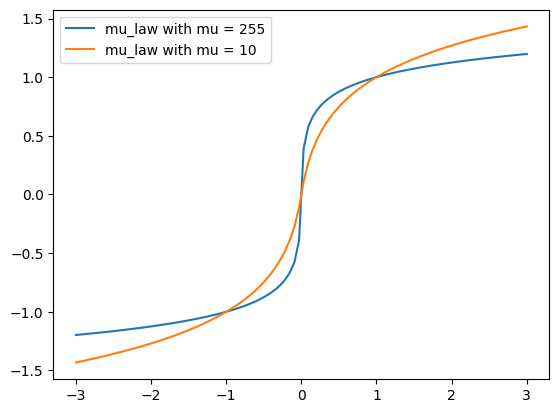

In [15]:
# Look at effect of apply mu law
arr = np.linspace(-3,3,100)
# plt.plot(arr, arr, label="Original")
plt.plot(arr, mu_law(arr), label="mu_law with mu = 255")
plt.plot(arr, mu_law(arr,10), label="mu_law with mu = 10")
plt.legend()
plt.show()

In [16]:
df_mu_law = mu_law(df/0.0012)
df_mu_law.describe()

F7-AVE         T3-AVE         T5-AVE        Fp1-AVE  \
count  529408.000000  529408.000000  529408.000000  529408.000000   
mean       -0.000647       0.000881       0.006100      -0.006516   
std         0.235436       0.207709       0.236218       0.258514   
min        -0.848718      -0.841210      -0.797569      -1.013405   
25%        -0.199165      -0.175726      -0.204602      -0.210149   
50%        -0.002012       0.001779       0.023637      -0.015783   
75%         0.197691       0.177430       0.216978       0.197658   
max         0.795357       0.781892       0.718526       1.012246   

              F3-AVE         C3-AVE         P3-AVE         O1-AVE  \
count  529408.000000  529408.000000  529408.000000  529408.000000   
mean       -0.000337      -0.000042      -0.000685       0.002798   
std         0.204143       0.192601       0.235170       0.231792   
min        -1.016385      -0.801567      -0.936905      -0.752819   
25%        -0.176140      -0.168290      -0.213031      -0.206772   
50%        -0.002459       0.000581      -0.000171       0.011688   
75%         0.175800       0.168829       0.212487       0.212259   
max         1.015134       0.832859       0.842263       0.759320   

              Fz-AVE         Cz-AVE         Pz-AVE         O2-AVE  \
count  529408.000000  529408.000000  529408.000000  529408.000000   
mean       -0.001462      -0.000223       0.001328       0.003834   
std         0.183232       0.292012       0.194198       0.231933   
min        -0.710537      -0.929150      -0.803848      -1.019199   
25%        -0.159015      -0.189472      -0.167438      -0.202549   
50%        -0.005463      -0.000710       0.005342       0.015245   
75%         0.155478       0.189009       0.170845       0.209953   
max         0.731972       0.992703       0.786301       1.020255   

              P4-AVE         C4-AVE         F4-AVE        Fp2-AVE  \
count  529408.000000  529408.000000  529408.000000  529408.000000   
mean        0.004238       0.001617       0.000086      -0.004007   
std         0.221561       0.199739       0.206319       0.470950   
min        -0.806254      -0.879851      -0.834972      -1.002799   
25%        -0.193684      -0.169600      -0.174915      -0.486547   
50%         0.016176       0.002924      -0.002137      -0.017914   
75%         0.201928       0.172067       0.174620       0.490662   
max         0.738389       0.890597       0.796484       0.849824   

              T6-AVE         T4-AVE         F8-AVE  
count  529408.000000  529408.000000  529408.000000  
mean        0.003017       0.000370      -0.001817  
std         0.233899       0.219513       0.253922  
min        -0.800160      -0.843199      -0.815922  
25%        -0.210009      -0.193946      -0.213516  
50%         0.011186       0.002527      -0.005076  
75%         0.216082       0.195133       0.211247  
max         0.781396       0.804406       0.810683

### KDE Graph (Original)

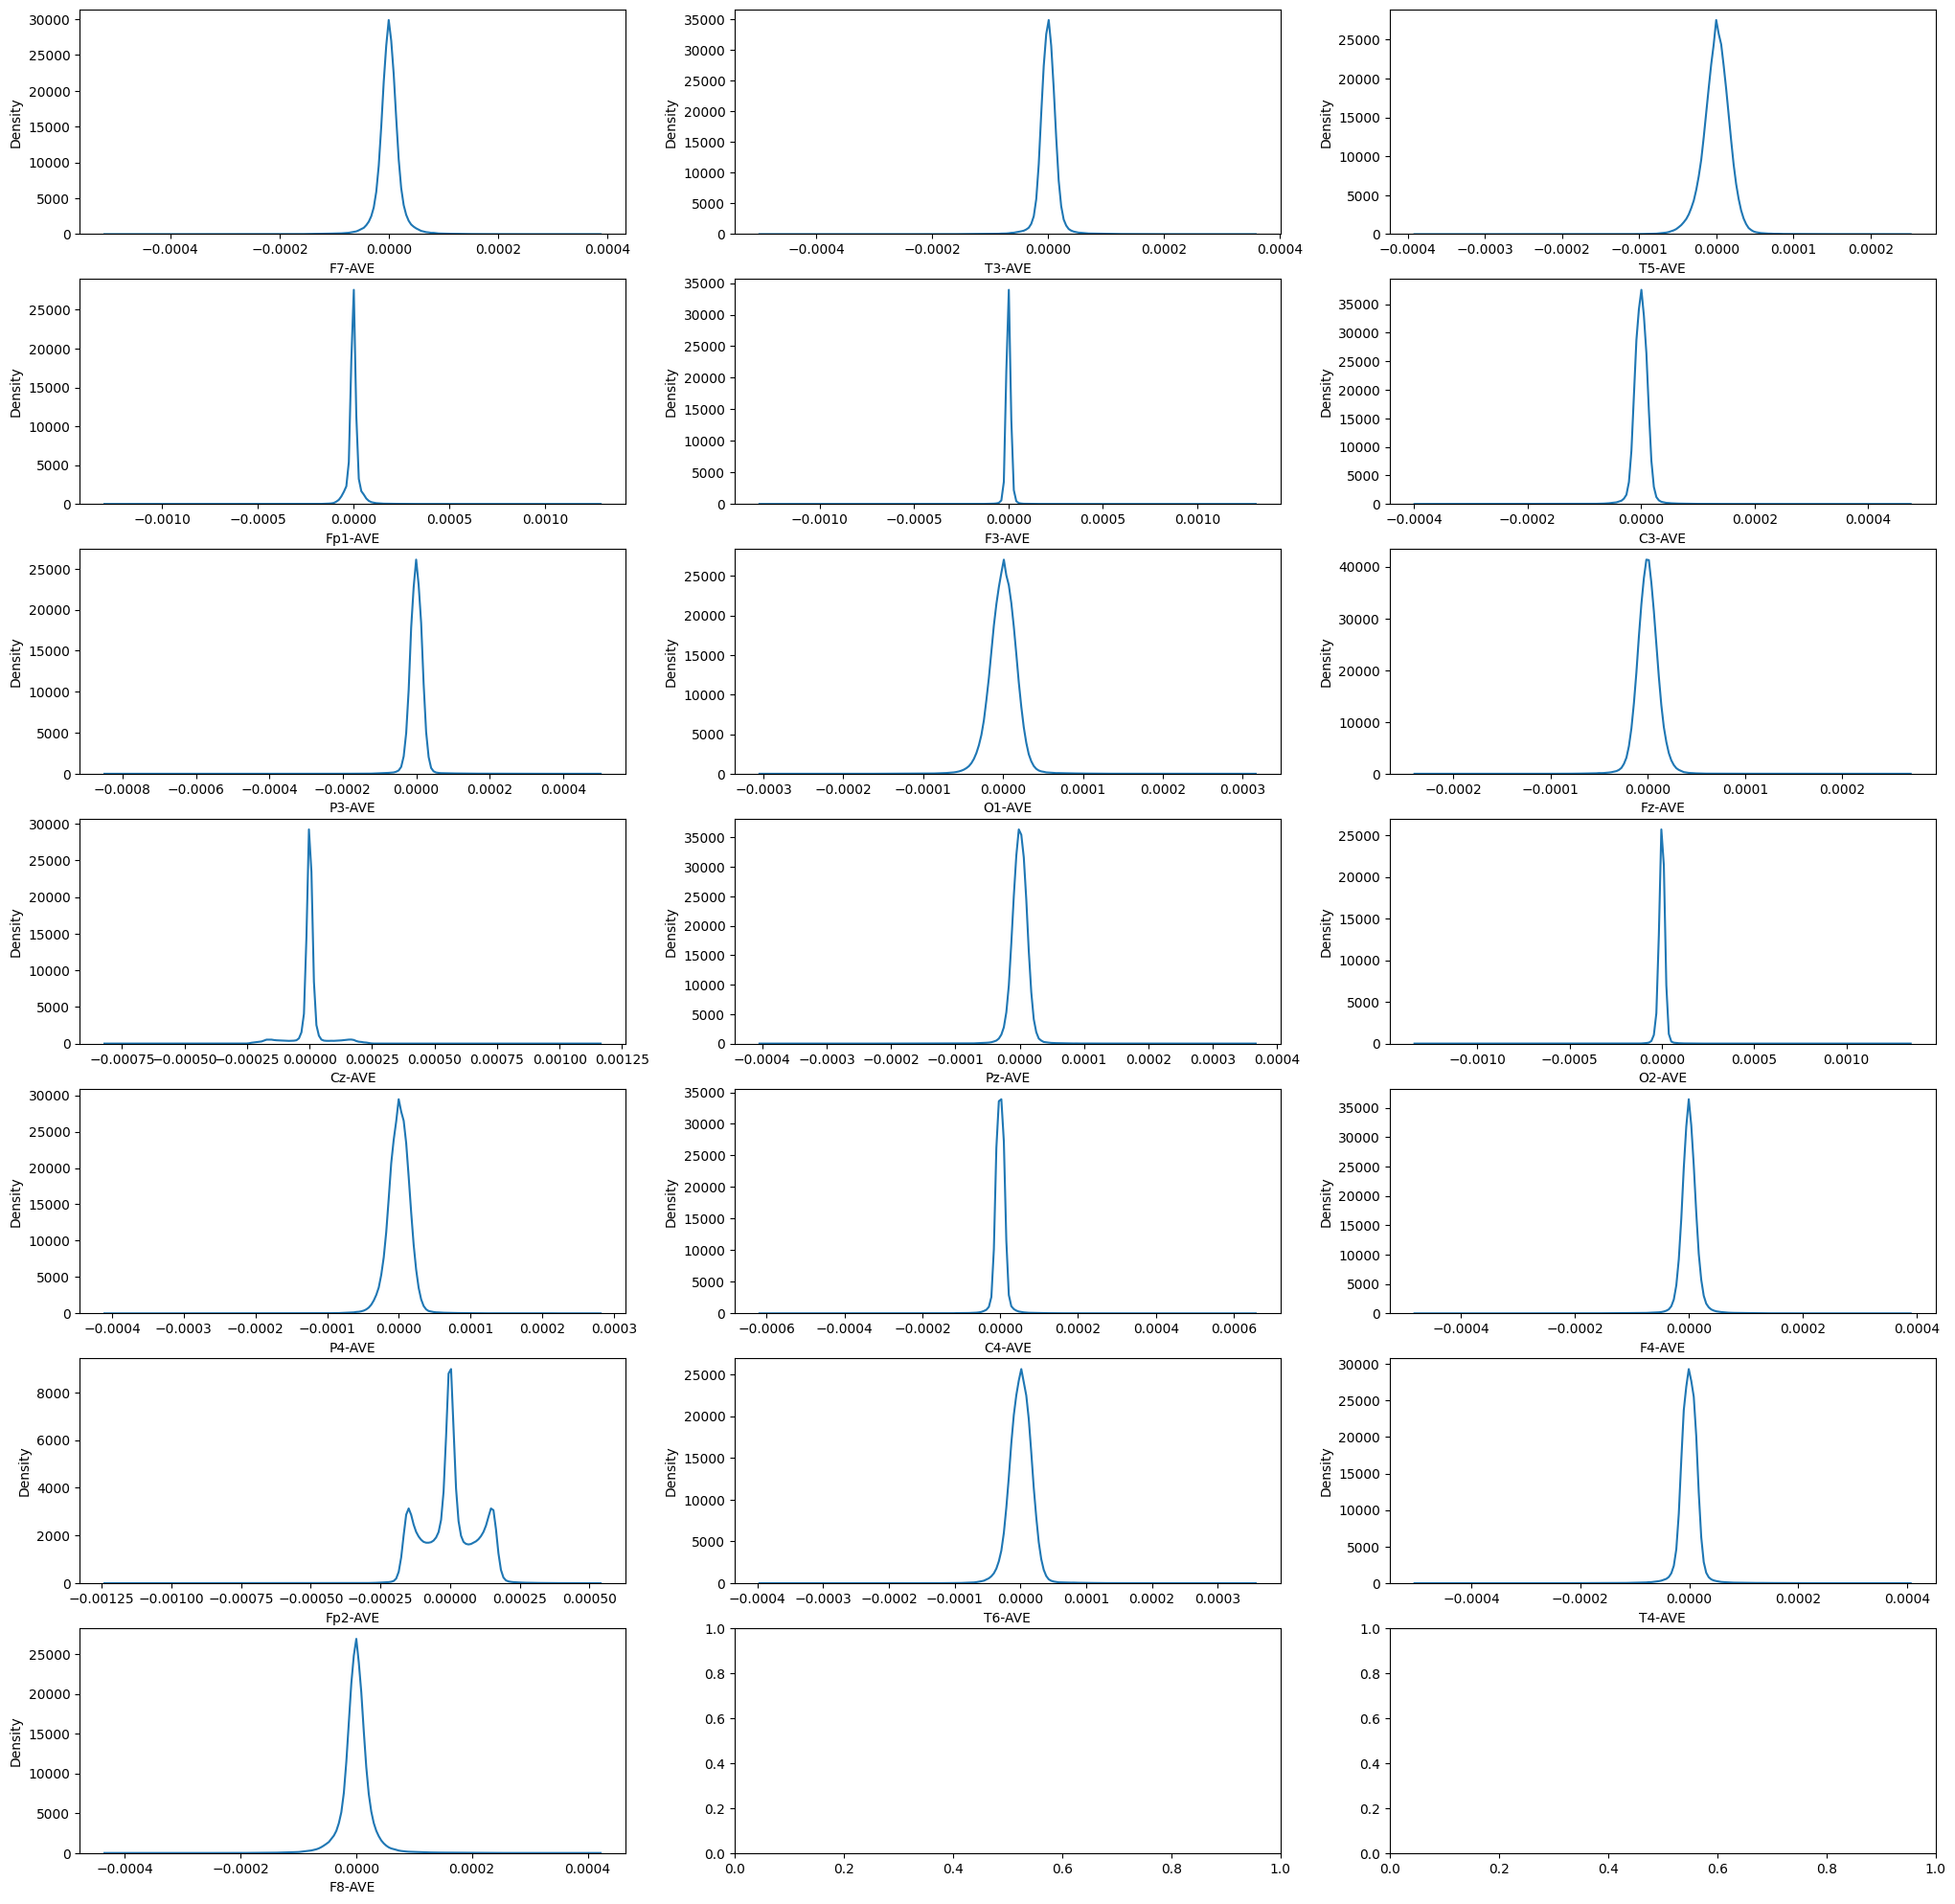

CPU times: total: 47.3 s
Wall time: 27 s


In [17]:
%%time
fig, ax = plt.subplots(7,3,figsize=(25,25))
for i,col in enumerate(df.columns):
    sns.kdeplot(data=df, x=col, ax=ax[i//3,i%3])
plt.show()

### KDE Graph (After normalize and apply mu_law)

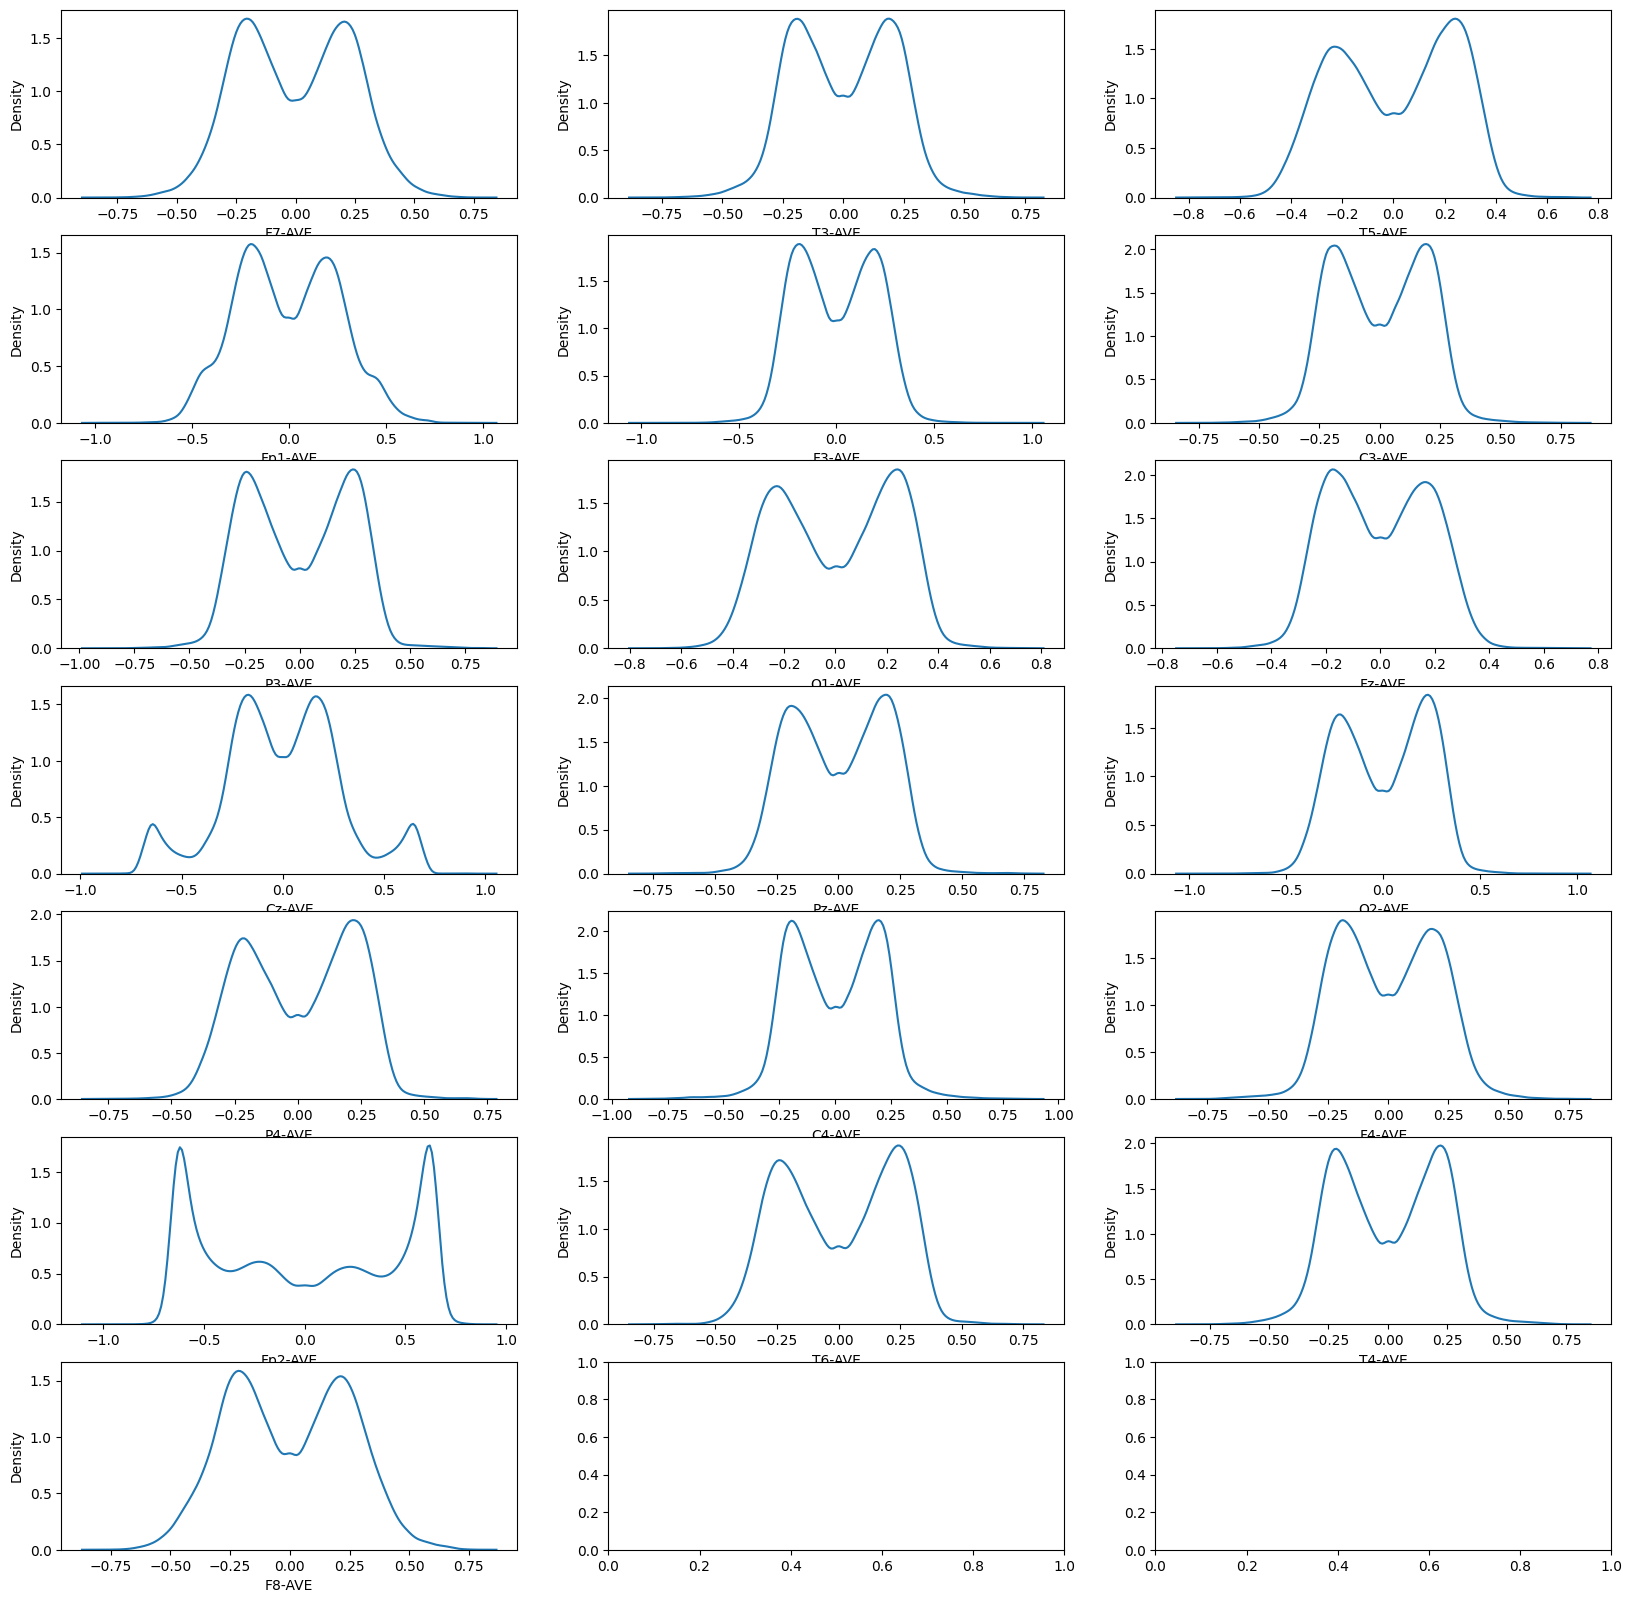

CPU times: total: 1min 28s
Wall time: 1min 7s


In [18]:
%%time
fig, ax = plt.subplots(7,3,figsize=(20,20))
for i,col in enumerate(df_mu_law.columns):
    sns.kdeplot(data=df_mu_law, x=col, ax=ax[i//3,i%3])
plt.show()

### 2D Graph (Visualize via matplotlib - Before & After)

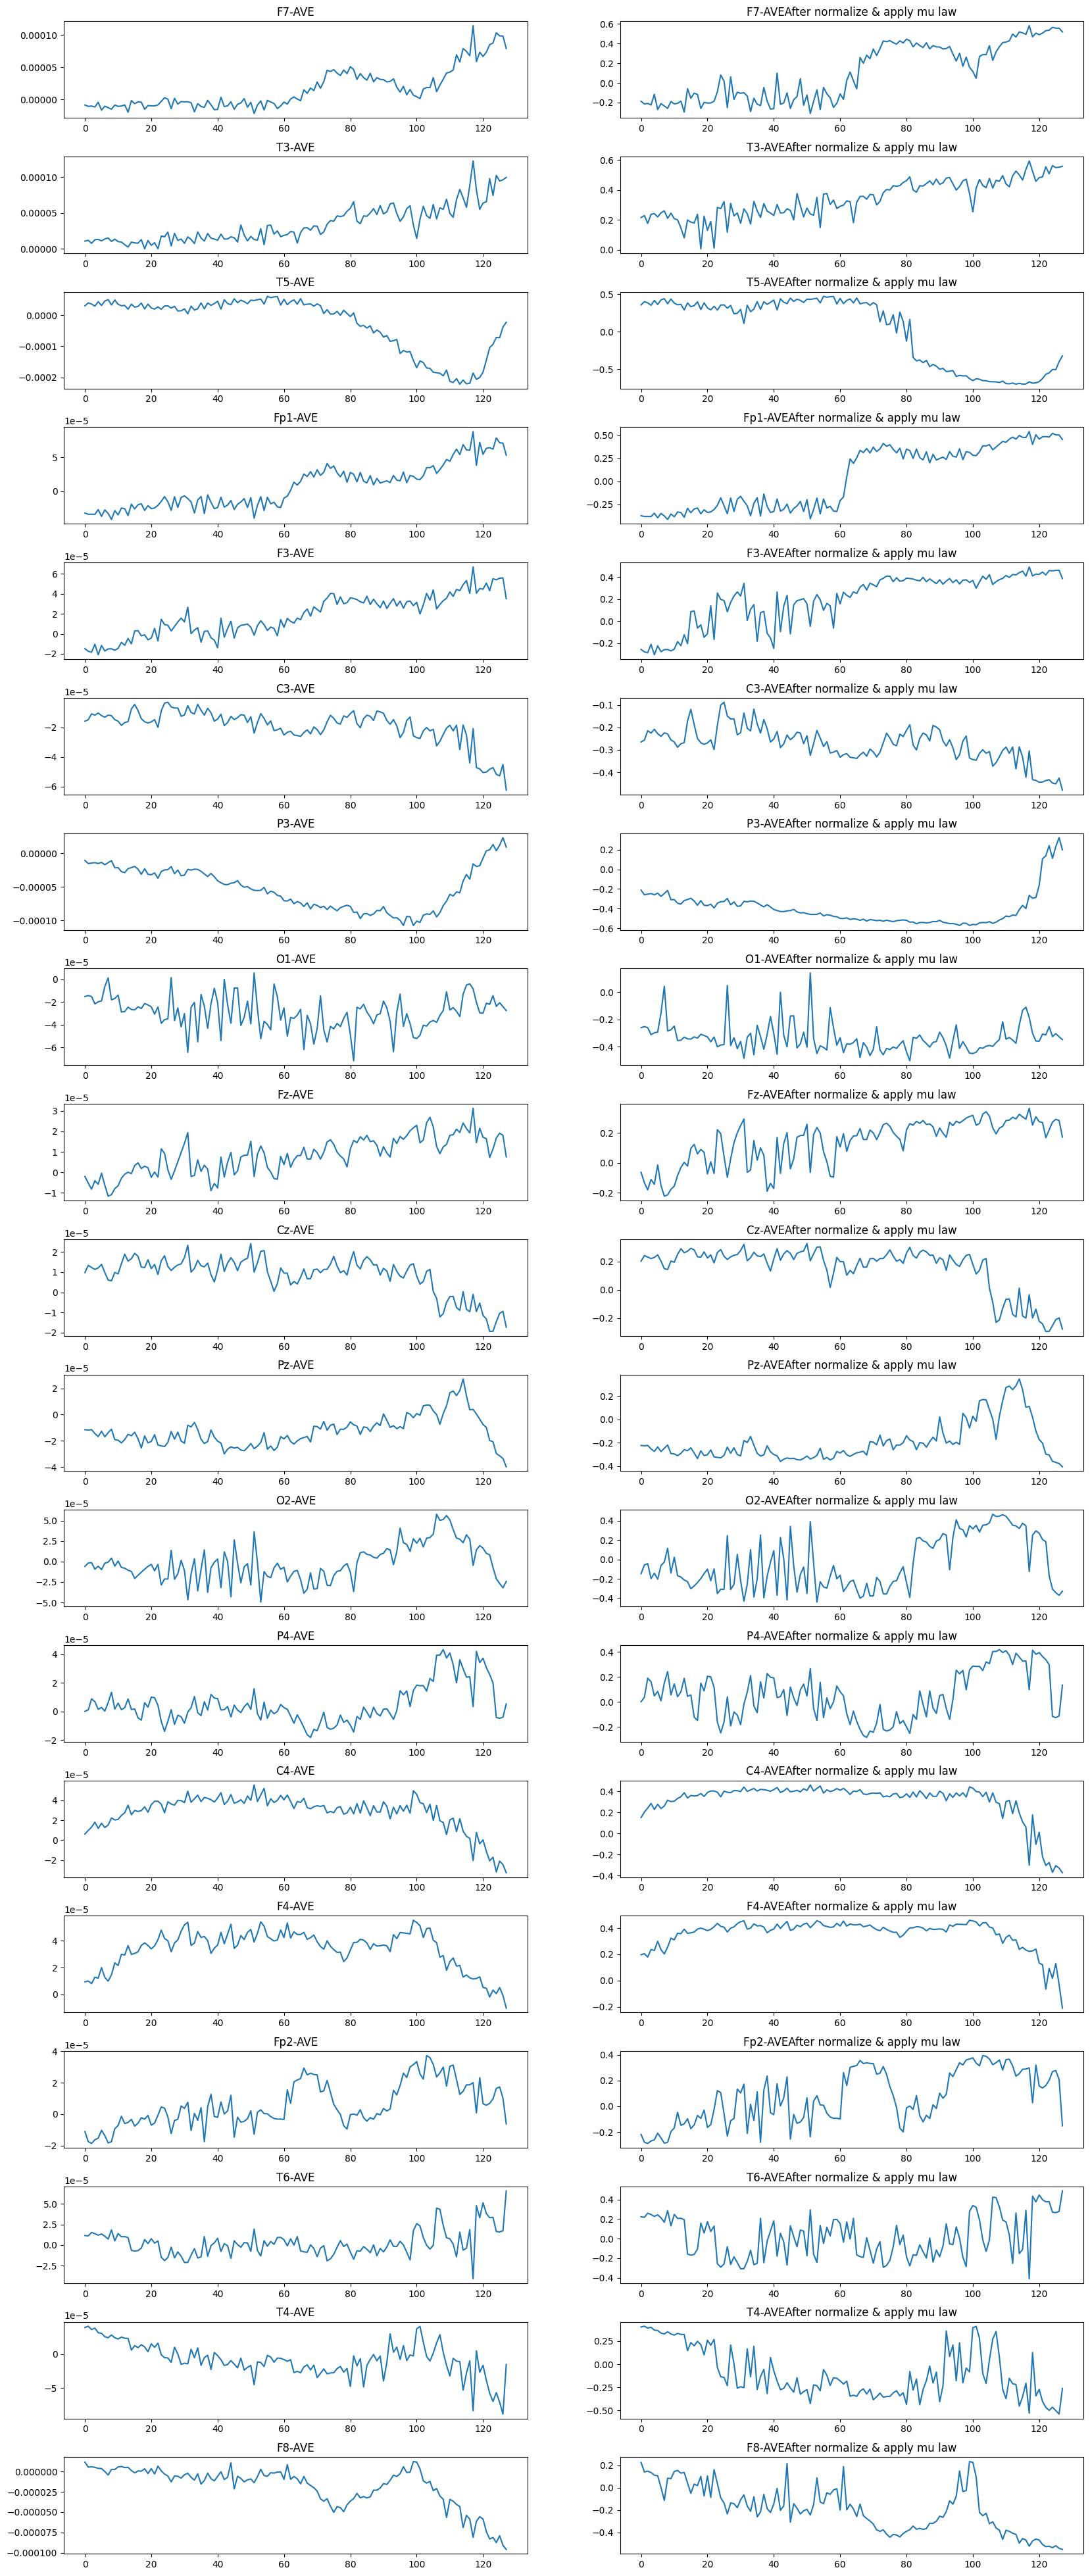

In [19]:
# This is a sample data with spike
START_INDEX = 105*NEW_FREQUENCY
END_INDEX   = 106*NEW_FREQUENCY

fig, axs = plt.subplots(len(AVE_CHANNELS_NAME), 2, figsize=(20, 50))
plt.subplots_adjust(hspace=0.4)

if type(df) != np.ndarray:
    df = df.to_numpy()
for i, col in enumerate(AVE_CHANNELS_NAME):
    axs[i][0].set_title(col)
    axs[i][0].plot(df[START_INDEX:END_INDEX,i])

if type(df_mu_law) != np.ndarray:
    df_mu_law = df_mu_law.to_numpy()
for i, col in enumerate(AVE_CHANNELS_NAME):
    axs[i][1].set_title(col + "After normalize & apply mu law")
    axs[i][1].plot(df_mu_law[START_INDEX:END_INDEX,i])
    
SAVE_PATH = f'{VIS_FILE_DIRC}/signal.png'
plt.savefig(SAVE_PATH, transparent = False,  facecolor = 'white')
plt.show()

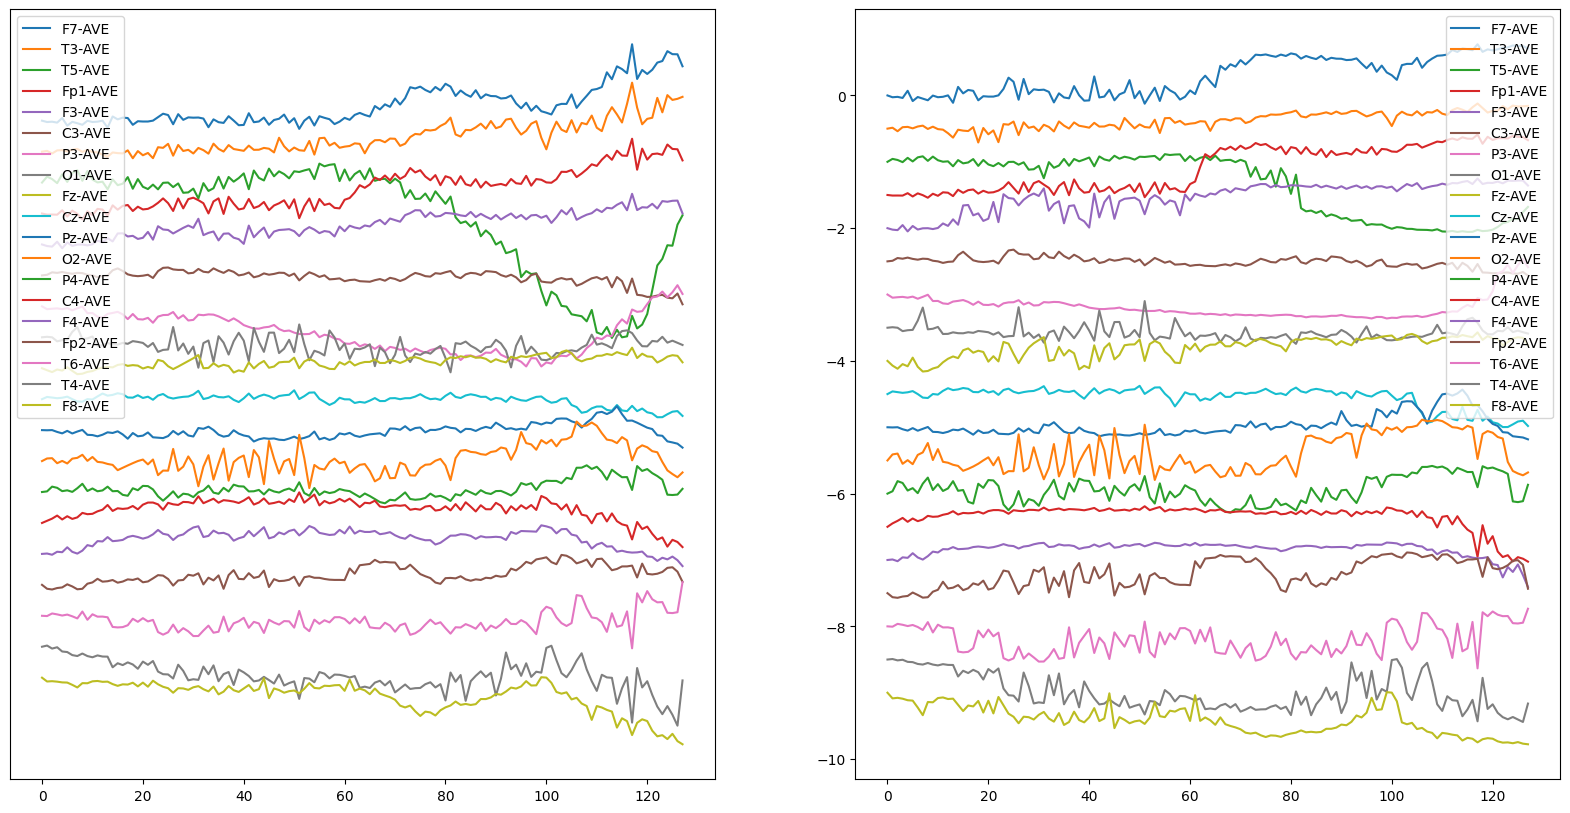

In [20]:
# START_INDEX = 269*NEW_FREQUENCY
# END_INDEX   = 271*NEW_FREQUENCY
START_INDEX = 105*NEW_FREQUENCY
END_INDEX   = 106*NEW_FREQUENCY


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)

if type(df) != np.ndarray:
    df = df.to_numpy()
seperate=5e-5
for i, col in enumerate(AVE_CHANNELS_NAME):
    axs[0].plot(df[START_INDEX:END_INDEX,i]-df[START_INDEX,i]-seperate*i, label=col)
    axs[0].set_yticks([])
    axs[0].legend()
    
if type(df_mu_law) != np.ndarray:
    df_mu_law = df_mu_law.to_numpy()
seperate=0.5
for i, col in enumerate(AVE_CHANNELS_NAME):
    axs[1].plot(df_mu_law[START_INDEX:END_INDEX,i]-df_mu_law[START_INDEX,i]-seperate*i, label=col)
    axs[1].legend()

SAVE_PATH = f'{VIS_FILE_DIRC}/signal.png'
plt.savefig(SAVE_PATH, transparent = False,  facecolor = 'white')
plt.show()

### 2D Graph with diffused signal

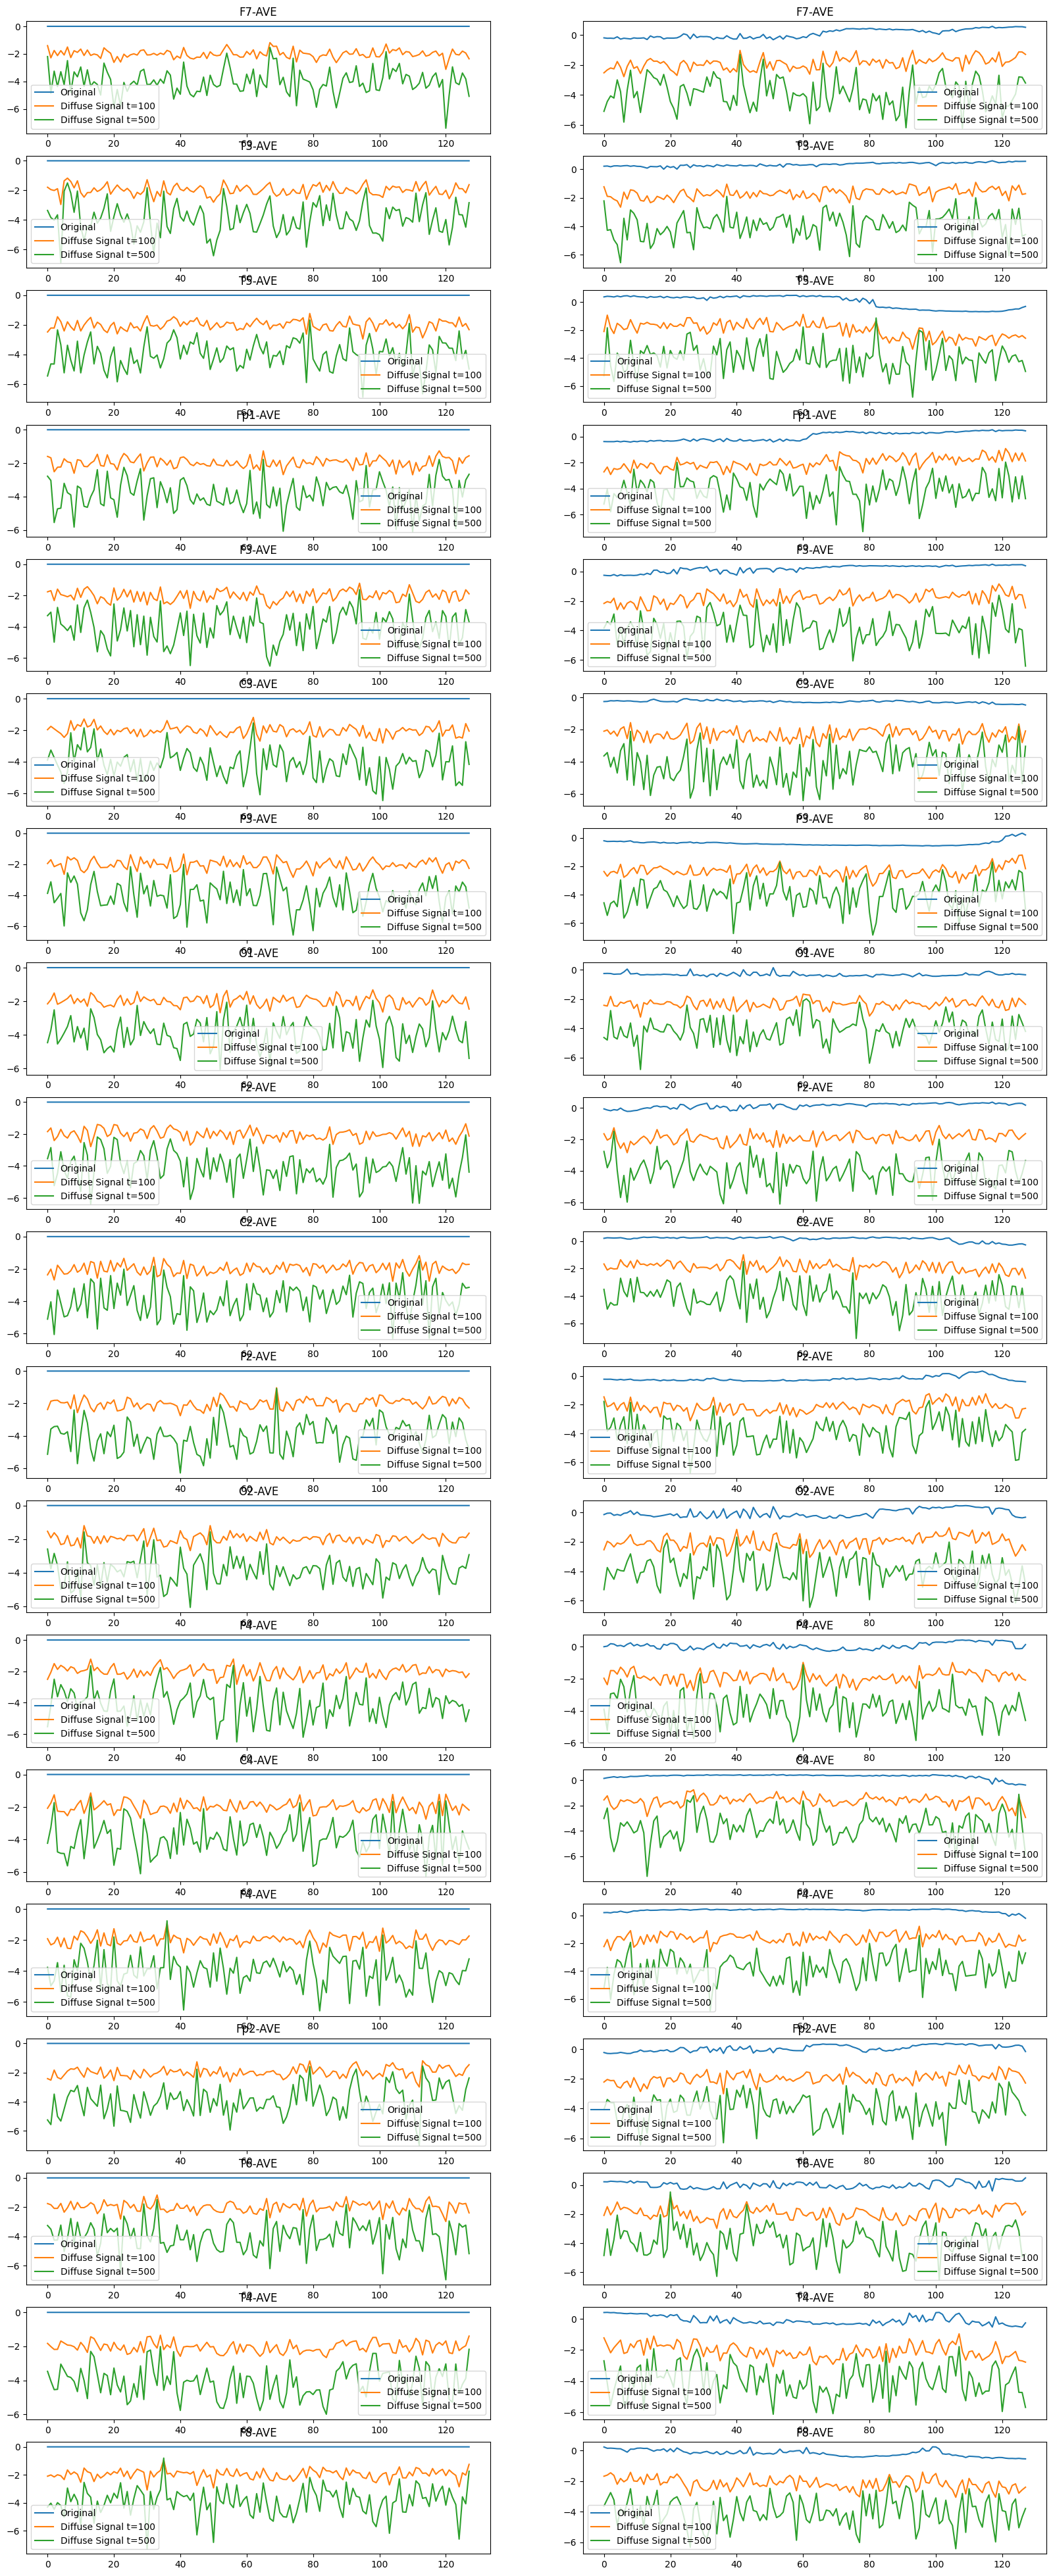

In [21]:
t_list    = [100, 500]
seperated = 2
fig, axs = plt.subplots(len(AVE_CHANNELS_NAME), 2, figsize=(20, 50))

def plot_eeg(df_used, k):
    x_0 = torch.tensor(df_used[START_INDEX:END_INDEX]) 
    eps = torch.randn_like(x_0) 
    x_t = []

    for t in t_list:
        x_t.append(q_sample(x_0, alphas_prod_p_sqrt[t-1], eps))

    for i, col in enumerate(AVE_CHANNELS_NAME):
        axs[i][k].set_title(col)
        axs[i][k].plot(x_0[:,i], label = "Original")
        for j in range(len(t_list)):
            axs[i][k].plot(x_t[j][:,i] - seperated*(j+1), label = f"Diffuse Signal t={t_list[j]}")                 
        axs[i][k].legend()

# For EEG data after apply average montage, band pass filter and resample to 128 Hz
plot_eeg(df, 0)
# plot_eeg(df/0.0012, 0) # After normalize, it also only have limited difference               
         
# For EEG data after apply average montage, band pass filter and resample to 128 Hz, normalize and apply mu law
plot_eeg(df_mu_law, 1)
                        

SAVE_PATH = f'{VIS_FILE_DIRC}\diffuseSignal.png'
plt.savefig(SAVE_PATH, transparent = False,  facecolor = 'white')
plt.show()


## Determine maximum value after normalize and apply mu law

In [22]:
# Create empty dataframe
df_summary = pd.DataFrame(columns=["EEG file"] + AVE_CHANNELS_NAME)
df_summary
def append_result_max(num, df_summary, df):
    df = mu_law(df / 0.0012)
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Max)"]  , df.max(axis=0).to_numpy() ))           # Add in the maximum value for each channel
    df_summary.loc[len(df_summary)] = np.concatenate(([str(num) + " (Min)"]  , df.min(axis=0).to_numpy() )) 
    
    return df_summary

In [23]:
%%time
for num in range(1,98):
    df = get_df(f'{CSV_FILE_DIRC}/eeg{num}.csv')
    df_summary = append_result_max(num, df_summary, df) 

The data from EEG_csv/eeg1.csv is loaded 
The data from EEG_csv/eeg2.csv is loaded 
The data from EEG_csv/eeg3.csv is loaded 
The data from EEG_csv/eeg4.csv is loaded 
The data from EEG_csv/eeg5.csv is loaded 
The data from EEG_csv/eeg6.csv is loaded 
The data from EEG_csv/eeg7.csv is loaded 
The data from EEG_csv/eeg8.csv is loaded 
The data from EEG_csv/eeg9.csv is loaded 
The data from EEG_csv/eeg10.csv is loaded 
The data from EEG_csv/eeg11.csv is loaded 
The data from EEG_csv/eeg12.csv is loaded 
The data from EEG_csv/eeg13.csv is loaded 
The data from EEG_csv/eeg14.csv is loaded 
The data from EEG_csv/eeg15.csv is loaded 
The data from EEG_csv/eeg16.csv is loaded 
The data from EEG_csv/eeg17.csv is loaded 
The data from EEG_csv/eeg18.csv is loaded 
The data from EEG_csv/eeg19.csv is loaded 
The data from EEG_csv/eeg20.csv is loaded 
The data from EEG_csv/eeg21.csv is loaded 
The data from EEG_csv/eeg22.csv is loaded 
The data from EEG_csv/eeg23.csv is loaded 
The data from EEG_cs

In [24]:
df_summary = df_summary.set_index('EEG file')
df_summary = df_summary.astype(np.float32)

In [25]:
print("For each channel:\n", pd.concat([df_summary.max(axis=0), df_summary.min(axis=0)], axis=1))
print("Maximum value overally:", df_summary.max().max())
print("Minimum value overally:", df_summary.min().min())

For each channel:
                 0         1
F7-AVE   1.088981 -1.107828
T3-AVE   1.107175 -1.107389
T5-AVE   1.115488 -1.094671
Fp1-AVE  1.164608 -1.164187
F3-AVE   1.130282 -1.139588
C3-AVE   1.114995 -1.073835
P3-AVE   1.114364 -1.141365
O1-AVE   1.122134 -1.152264
Fz-AVE   1.144335 -1.146434
Cz-AVE   1.131383 -1.145955
Pz-AVE   1.151132 -1.153676
O2-AVE   1.165920 -1.137633
P4-AVE   1.127180 -1.141262
C4-AVE   1.129705 -1.143751
F4-AVE   1.147980 -1.142657
Fp2-AVE  1.178640 -1.164509
T6-AVE   1.129630 -1.132936
T4-AVE   1.139602 -1.139939
F8-AVE   1.147485 -1.147984
Maximum value overally: 1.1786405
Minimum value overally: -1.1645086


* From here, the value use to normalize the EEG data to range between [-1, 1] will be 1.18